<a href="https://colab.research.google.com/github/enitin-agarwal/azureforaws/blob/master/Mimic3_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -U pip setuptools wheel
! pip install -U spacy
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.0 MB/s eta 0:00:00
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.7.1
    Uninstalling en-core-web-sm-3.7.1:
      Successfully uninstalled en-core-web-sm-3.7.1
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
!pip install -U spacy
!pip install scispacy
!pip install -U spacy pydantic


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 130.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.2/920.2 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 131.4 MB/s eta 0:00:00
  Attempting uninstall: blis
    Found existing installation: blis 1.2.0
    Uninstalling blis-1.2.0:
      Successfully uninstalled blis-1.2.0
  Attempting uninstall: thinc
    Found existing installation: thinc 8.3.4
    Uninstalling thinc-8.3.4:
      Successfully uninstalled thinc-8.3.4
  Attempting uninstall: spacy
    Found existing installation: spacy 3.8.4
    Uninstalling spacy-3.8.4:
      Successfully uninstalled spacy-3.8.4
  Using cached spacy-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached thinc-8.3.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached blis-1.2.0-cp311-cp3

In [ ]:
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_craft_md-0.4.0.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_jnlpba_md-0.2.4.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bionlp13cg_md-0.2.4.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [3]:

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
print('Authenticated')

# Initialize BigQuery Client
client = bigquery.Client(project='physionet-data')

# load the dataset list
datasets = client.list_datasets()



Authenticated


In [4]:
import pandas as pd
import spacy
import scispacy
import gensim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import AutoModel, AutoTokenizer
import torch
import seaborn as sns
from google.cloud import bigquery
# Make pandas dataframes prettier
from IPython.display import display, HTML

In [5]:
%%bigquery --project ultimate-balm-449016-q6

# Directly embed the query for notes
#SELECT SUBJECT_ID, HADM_ID, TEXT, CATEGORY
#FROM `physionet-data.mimiciii_notes.noteevents`
#WHERE CATEGORY = 'Discharge summary' limit 100000
SELECT
    n.SUBJECT_ID,
    n.HADM_ID,
    n.TEXT,
    n.CATEGORY,
    a.SUBJECT_ID,
    a.HADM_ID
FROM
    `physionet-data.mimiciii_notes.noteevents` AS n
INNER JOIN
    `physionet-data.mimiciii_demo.diagnoses_icd` AS a
ON
    n.SUBJECT_ID = a.SUBJECT_ID AND n.HADM_ID = a.HADM_ID
WHERE
    a.ICD9_CODE like '410%' OR  a.ICD9_CODE like '411%' OR  a.ICD9_CODE like '412%' OR  a.ICD9_CODE like '413%' OR  a.ICD9_CODE like '414%' OR  a.ICD9_CODE like '428%' OR  a.ICD9_CODE like '429%'
    and n.CATEGORY = 'Discharge summary'
LIMIT 100000



Query is running:   0%|          |

Downloading:   0%|          |

,SUBJECT_ID,HADM_ID,TEXT,CATEGORY,SUBJECT_ID_1,HADM_ID_1
0,10094,122928,"ADDENDUM:\nPt more restless/agitated, SOB, tac...",Nursing/other,10094,122928
1,10013,165520,"MICU A NSG 7A-7P\nPT WITH FAILING VS, SEE CARE...",Nursing/other,10013,165520
2,44222,192189,"73M with PMH CAD s/p DES to RCA and LCX, DMII,...",Nursing,44222,192189
3,10132,197611,Smicu nsg admission note\n65 women recently dx...,Nursing/other,10132,197611
4,10044,124073,[**2152-10-2**] 1:07 PM\n CT HEAD W/O CONTRAST...,Radiology,10044,124073
...,...,...,...,...,...,...
4720,10027,199395,Supraventricular rhythm\nLow amplitude P waves...,ECG,10027,199395
4721,10027,199395,PATIENT/TEST INFORMATION:\nIndication: Intraop...,Echo,10027,199395
4722,10027,199395,PATIENT/TEST INFORMATION:\nIndication: Intraop...,Echo,10027,199395
4723,10027,199395,Resp Care\nPt remained intubated anda ventilat...,Nursing/other,10027,199395


In [6]:
heart_patients_df = _
display(heart_patients_df)

,SUBJECT_ID,HADM_ID,TEXT,CATEGORY,SUBJECT_ID_1,HADM_ID_1
0,10094,122928,"ADDENDUM:\nPt more restless/agitated, SOB, tac...",Nursing/other,10094,122928
1,10013,165520,"MICU A NSG 7A-7P\nPT WITH FAILING VS, SEE CARE...",Nursing/other,10013,165520
2,44222,192189,"73M with PMH CAD s/p DES to RCA and LCX, DMII,...",Nursing,44222,192189
3,10132,197611,Smicu nsg admission note\n65 women recently dx...,Nursing/other,10132,197611
4,10044,124073,[**2152-10-2**] 1:07 PM\n CT HEAD W/O CONTRAST...,Radiology,10044,124073
...,...,...,...,...,...,...
4720,10027,199395,Supraventricular rhythm\nLow amplitude P waves...,ECG,10027,199395
4721,10027,199395,PATIENT/TEST INFORMATION:\nIndication: Intraop...,Echo,10027,199395
4722,10027,199395,PATIENT/TEST INFORMATION:\nIndication: Intraop...,Echo,10027,199395
4723,10027,199395,Resp Care\nPt remained intubated anda ventilat...,Nursing/other,10027,199395


In [7]:
# Process a sample note (or loop over many)
nlp_spacy = spacy.load("en_core_web_sm")
sample_text = heart_patients_df["TEXT"].iloc[0]
doc_spacy = nlp_spacy(sample_text)

# Tokenization, POS tagging, lemmatization
print("\n--- spaCy Analysis ---")
for token in doc_spacy:
    print(f"Token: {token.text}\tPOS: {token.pos_}\tLemma: {token.lemma_}")

# Named Entity Recognition
print("\nNamed Entities (spaCy):")
for ent in doc_spacy.ents:
    print(f"Entity: {ent.text}\tLabel: {ent.label_}")


--- spaCy Analysis ---
Token: ADDENDUM	POS: PROPN	Lemma: ADDENDUM
Token: :	POS: PUNCT	Lemma: :
Token: 
	POS: SPACE	Lemma: 

Token: Pt	POS: VERB	Lemma: pt
Token: more	POS: ADV	Lemma: more
Token: restless	POS: ADJ	Lemma: restless
Token: /	POS: SYM	Lemma: /
Token: agitated	POS: ADJ	Lemma: agitated
Token: ,	POS: PUNCT	Lemma: ,
Token: SOB	POS: PROPN	Lemma: SOB
Token: ,	POS: PUNCT	Lemma: ,
Token: tachypneic	POS: VERB	Lemma: tachypneic
Token: with	POS: ADP	Lemma: with
Token: sats	POS: NOUN	Lemma: sat
Token: in	POS: ADP	Lemma: in
Token: 80	POS: NUM	Lemma: 80
Token: 's	POS: PART	Lemma: 's
Token: at	POS: ADP	Lemma: at
Token: 0600	POS: NUM	Lemma: 0600
Token: .	POS: PUNCT	Lemma: .
Token: Found	POS: VERB	Lemma: find
Token: to	POS: PART	Lemma: to
Token: be	POS: AUX	Lemma: be
Token: in	POS: ADP	Lemma: in
Token: stool	POS: NOUN	Lemma: stool
Token: .	POS: PUNCT	Lemma: .
Token: He	POS: PRON	Lemma: he
Token: was	POS: AUX	Lemma: be
Token: cleaned	POS: VERB	Lemma: clean
Token: up	POS: ADP	Lemma: up
Token:

In [ ]:
# For inline display of entities:
html_ent = spacy.displacy.render(doc_spacy, style="ent", jupyter=True)

# For inline dependency visualization:
html_dep = spacy.displacy.render(doc_spacy, style="dep", jupyter=True)
from IPython.core.display import display, HTML
display(HTML(html_dep))


<IPython.core.display.HTML object>

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_md-0.4.0.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_craft_md-0.4.0.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_jnlpba_md-0.4.0.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_md-0.4.0.tar.gz (125.2 MB)
  Preparing metadata (setup.py) ... done
  Using cached spacy-3.0.9-cp311-cp311-linux_x86_64.whl
  Using cached thinc-8.0.17-cp311-cp311-linux_x86_64.whl
  Using cached blis-0.7.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.4 kB)
  Using cached pydantic-1.8.2-py3-none-any.whl.metadata (103 kB)
Using cached blis-0.7.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.2 MB)
Using cached pydantic-1.8.2-py3-none-any.whl (126 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.10.6
    Uninstalling pydantic-2.10.6:
      Successfully uninstalled pydantic-2.10.6
  Attempting uninstall: blis
    Found existing installation: blis 1.2.0
    Uninstalling blis-1.2.0:
      Successfully uninstalled blis-1.2.0
  Attempting uninstall: thinc
    Found existing installation: thinc 8.3.4
    Uninstalling thinc-8.3

In [ ]:
nlp_scispacy = spacy.load("en_core_sci_md")

doc_scispacy = nlp_scispacy(sample_text)
print("\n--- SciSpacy Analysis ---")
print("Tokens and Entities from SciSpacy:")
for token in doc_scispacy:
    print(f"Token: {token.text}\tPOS: {token.pos_}\tLemma: {token.lemma_}")
print("\nNamed Entities (SciSpacy):")
for ent in doc_scispacy.ents:
    print(f"Entity: {ent.text}\tLabel: {ent.label_}")

/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_md' (0.4.0) was trained with spaCy v3.0.1 and may not be 100% compatible with the current version (3.8.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  



--- SciSpacy Analysis ---
Tokens and Entities from SciSpacy:
Token: ADDENDUM	POS: NOUN	Lemma: addendum
Token: :	POS: PUNCT	Lemma: :
Token: 
	POS: SPACE	Lemma: 

Token: Pt	POS: PROPN	Lemma: Pt
Token: more	POS: ADV	Lemma: more
Token: restless/agitated	POS: VERB	Lemma: restless/agitate
Token: ,	POS: PUNCT	Lemma: ,
Token: SOB	POS: NOUN	Lemma: sob
Token: ,	POS: PUNCT	Lemma: ,
Token: tachypneic	POS: ADJ	Lemma: tachypneic
Token: with	POS: ADP	Lemma: with
Token: sats	POS: NOUN	Lemma: sat
Token: in	POS: ADP	Lemma: in
Token: 80	POS: NUM	Lemma: 80
Token: 's	POS: VERB	Lemma: be
Token: at	POS: ADP	Lemma: at
Token: 0600	POS: NUM	Lemma: 0600
Token: .	POS: PUNCT	Lemma: .
Token: Found	POS: VERB	Lemma: find
Token: to	POS: PART	Lemma: to
Token: be	POS: VERB	Lemma: be
Token: in	POS: ADP	Lemma: in
Token: stool	POS: NOUN	Lemma: stool
Token: .	POS: PUNCT	Lemma: .
Token: He	POS: PRON	Lemma: he
Token: was	POS: VERB	Lemma: be
Token: cleaned	POS: VERB	Lemma: clean
Token: up	POS: ADP	Lemma: up
Token: and	POS: CC

In [ ]:
sentences = [text.split() for text in heart_patients_df["TEXT"].dropna()]

# Train Word2Vec model
word2vec_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)
word_vectors = word2vec_model.wv

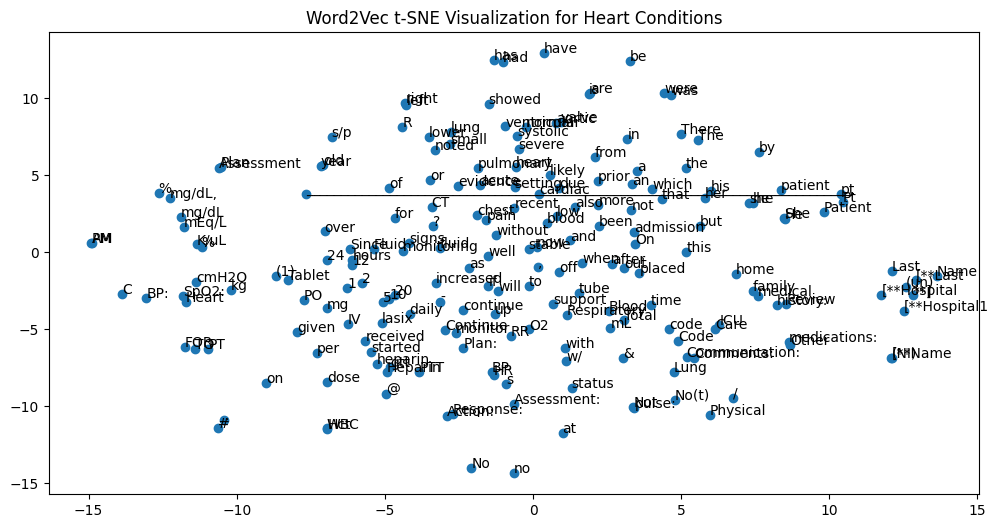

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNE Visualization Function
def tsne_plot(model, title):
    words = list(model.index_to_key)[:200]  # limiting to first 200 words
    X = model[words]
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(12, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, xy=(X_tsne[i, 0], X_tsne[i, 1]))
    plt.title(title)
    plt.show()

# Assuming `word_vectors` is your trained Word2Vec model's .wv attribute
tsne_plot(word_vectors, "Word2Vec t-SNE Visualization for Heart Conditions")


In [ ]:
!pip install ctakesclient
!pip install --upgrade ctakesclient

In [ ]:
import nest_asyncio
nest_asyncio.apply() #patch event loop to make it reentrant

import asyncio
from ctakesclient.client import extract

async def extract_ctakes_entities(text):
    try:
        response = await extract(text)
        return response.get("entities", [])
    except Exception as e:
        print(f"Error extracting cTAKES entities: {e}")
        return []

def extract_entities_sync(text):
    loop = asyncio.get_event_loop()
    #loop.run_until_complete(extract_ctakes_entities(text))
    return loop.run_until_complete(extract_ctakes_entities(text))


heart_patients_df["ctakes_entities"] = heart_patients_df["TEXT"].apply(extract_entities_sync)
print("\ncTAKES Extracted Entities Sample:")
print(heart_patients_df[["TEXT", "ctakes_entities"]].head())


Streaming output truncated to the last 5000 lines.
Error extracting cTAKES entities: Client error '404 Not Found' for url 'http://localhost:8080/ctakes-web-rest/service/analyze'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/404
Error extracting cTAKES entities: Client error '404 Not Found' for url 'http://localhost:8080/ctakes-web-rest/service/analyze'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/404
Error extracting cTAKES entities: Client error '404 Not Found' for url 'http://localhost:8080/ctakes-web-rest/service/analyze'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/404
Error extracting cTAKES entities: Client error '404 Not Found' for url 'http://localhost:8080/ctakes-web-rest/service/analyze'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/404
Error extracting cTAKES entities: Client error '404 Not Found' for url 'http://localh

/usr/lib/python3.11/selectors.py:190: RuntimeWarning: coroutine 'extract_ctakes_entities' was never awaited
  return mapping[fileobj]


Error extracting cTAKES entities: Client error '404 Not Found' for url 'http://localhost:8080/ctakes-web-rest/service/analyze'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/404
Error extracting cTAKES entities: Client error '404 Not Found' for url 'http://localhost:8080/ctakes-web-rest/service/analyze'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/404
Error extracting cTAKES entities: Client error '404 Not Found' for url 'http://localhost:8080/ctakes-web-rest/service/analyze'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/404
Error extracting cTAKES entities: Client error '404 Not Found' for url 'http://localhost:8080/ctakes-web-rest/service/analyze'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/404
Error extracting cTAKES entities: Client error '404 Not Found' for url 'http://localhost:8080/ctakes-web-rest/service/analyze'
For more 

In [8]:
# Install transformers if not already installed (optional, usually pre-installed in Colab)
!pip install transformers

import torch
from transformers import AutoModel, AutoTokenizer

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load ClinicalBERT tokenizer and model, then move the model to the selected device
clinicalbert_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinicalbert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)

def get_clinicalbert_embeddings(text):
    # Tokenize the input text and move inputs to the device
    inputs = clinicalbert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform inference with no gradient calculation
    with torch.no_grad():
        outputs = clinicalbert_model(**inputs)

    # Compute the mean of the last hidden state, move result to CPU, and convert to numpy array
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding

# Assuming heart_summary is a DataFrame that contains the TEXT column along with SUBJECT_ID and HADM_ID.
# Compute and add the embeddings to a new column
heart_patients_df["clinicalbert_embeddings"] = heart_patients_df["TEXT"].apply(get_clinicalbert_embeddings)

# Display a sample of the embeddings
print("\nClinicalBERT Embeddings Sample:")
print(heart_patients_df[["SUBJECT_ID", "HADM_ID", "clinicalbert_embeddings"]].head())


Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]


ClinicalBERT Embeddings Sample:
   SUBJECT_ID  HADM_ID                            clinicalbert_embeddings
0       10094   122928  [-0.07239876, -0.076681755, -0.25584415, 0.185...
1       10013   165520  [0.0013990428, -0.27690914, -0.14947282, 0.127...
2       44222   192189  [0.046721086, 0.0010364819, -0.13795063, 0.024...
3       10132   197611  [0.0057239225, -0.1706075, -0.07456642, 0.1312...
4       10044   124073  [0.17802963, -0.17454174, -0.1877661, 0.148122...


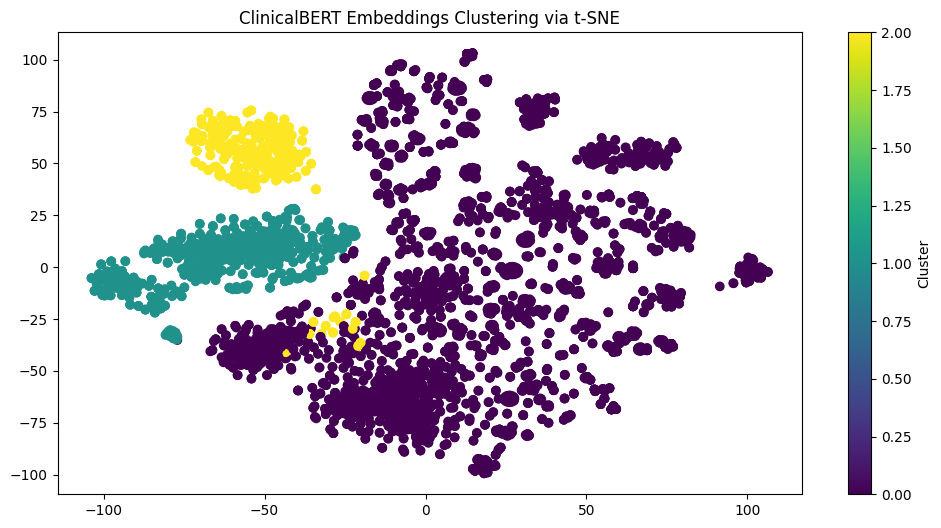


ClinicalBERT Embeddings Sample:
   SUBJECT_ID  HADM_ID                            clinicalbert_embeddings  \
0       10094   122928  [-0.07239876, -0.076681755, -0.25584415, 0.185...   
1       10013   165520  [0.0013990428, -0.27690914, -0.14947282, 0.127...   
2       44222   192189  [0.046721086, 0.0010364819, -0.13795063, 0.024...   
3       10132   197611  [0.0057239225, -0.1706075, -0.07456642, 0.1312...   
4       10044   124073  [0.17802963, -0.17454174, -0.1877661, 0.148122...   

   cluster  
0        0  
1        0  
2        0  
3        0  
4        1  


In [9]:
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.cluster import KMeans
import numpy as np
# Cluster embeddings using KMeans
embeddings = np.stack(heart_patients_df["clinicalbert_embeddings"].values)
kmeans = KMeans(n_clusters=3, random_state=42).fit(embeddings)
heart_patients_df["cluster"] = kmeans.labels_

# t-SNE visualization of clusters
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings)
plt.figure(figsize=(12, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap="viridis")
plt.colorbar(label="Cluster")
plt.title("ClinicalBERT Embeddings Clustering via t-SNE")
plt.show()

print("\nClinicalBERT Embeddings Sample:")
print(heart_patients_df[["SUBJECT_ID", "HADM_ID", "clinicalbert_embeddings", "cluster"]].head())

In [15]:
!pip install pyLDAvis

from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import nltk

nltk.download('stopwords')
# Prepare texts: simple tokenization and stopword removal
stop_words = set(stopwords.words('english'))
texts = [
    [word for word in text.lower().split() if word not in stop_words]
    for text in heart_patients_df["TEXT"].dropna()
]

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model on the corpus (e.g., 3 topics)
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, random_state=42, passes=10)
topics = lda_model.print_topics(num_words=5)
print("\nLDA Topics:")
for topic in topics:
    print(topic)

# Visualize topics with pyLDAvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



LDA Topics:
(0, '0.023*"pt" + 0.008*"plan:" + 0.008*"assessment:" + 0.007*"action:" + 0.007*"response:"')
(1, '0.031*"-" + 0.015*"ml" + 0.012*"/" + 0.007*"." + 0.007*"pm"')
(2, '0.008*"patient" + 0.008*"left" + 0.006*"right" + 0.005*"mg" + 0.005*"______________________________________________________________________________"')


In [ ]:
%%bigquery --project ultimate-balm-449016-q6

# Directly embed the query for notes
#SELECT SUBJECT_ID, HADM_ID, TEXT, CATEGORY
#FROM `physionet-data.mimiciii_notes.noteevents`
#WHERE CATEGORY = 'Discharge summary' limit 100000
SELECT
    n.SUBJECT_ID,
    n.HADM_ID,
    n.TEXT,
    n.CATEGORY,
    a.SUBJECT_ID,
    a.HADM_ID
FROM
    `physionet-data.mimiciii_notes.noteevents` AS n
INNER JOIN
    `physionet-data.mimiciii_demo.diagnoses_icd` AS a
ON
    n.SUBJECT_ID = a.SUBJECT_ID AND n.HADM_ID = a.HADM_ID
WHERE
    a.ICD9_CODE = '99591'
    and n.CATEGORY = 'Discharge summary'
LIMIT 100000


Query is running:   0%|          |

Downloading:   0%|          |

,SUBJECT_ID,HADM_ID,TEXT,CATEGORY,SUBJECT_ID_1,HADM_ID_1
0,10006,142345,Admission Date: [**2164-10-23**] ...,Discharge summary,10006,142345
1,10124,170883,Admission Date: [**2192-4-16**] ...,Discharge summary,10124,170883
2,40612,104697,Admission Date: [**2159-11-17**] ...,Discharge summary,40612,104697
3,40655,126002,Admission Date: [**2144-7-18**] ...,Discharge summary,40655,126002
4,10088,149044,Admission Date: [**2107-5-12**] ...,Discharge summary,10088,149044
5,41976,180546,Admission Date: [**2201-5-12**] ...,Discharge summary,41976,180546
6,10038,111115,Admission Date: [**2144-2-9**] D...,Discharge summary,10038,111115
7,41976,174863,Admission Date: [**2201-8-10**] ...,Discharge summary,41976,174863
8,10132,197611,Admission Date: [**2123-8-23**] ...,Discharge summary,10132,197611
9,41976,149469,Admission Date: [**2202-9-16**] ...,Discharge summary,41976,149469


In [ ]:
notes_df = _
display(notes_df)  # Optional: To view the DataFrame

,SUBJECT_ID,HADM_ID,TEXT,CATEGORY,SUBJECT_ID_1,HADM_ID_1
0,10006,142345,Admission Date: [**2164-10-23**] ...,Discharge summary,10006,142345
1,10124,170883,Admission Date: [**2192-4-16**] ...,Discharge summary,10124,170883
2,40612,104697,Admission Date: [**2159-11-17**] ...,Discharge summary,40612,104697
3,40655,126002,Admission Date: [**2144-7-18**] ...,Discharge summary,40655,126002
4,10088,149044,Admission Date: [**2107-5-12**] ...,Discharge summary,10088,149044
5,41976,180546,Admission Date: [**2201-5-12**] ...,Discharge summary,41976,180546
6,10038,111115,Admission Date: [**2144-2-9**] D...,Discharge summary,10038,111115
7,41976,174863,Admission Date: [**2201-8-10**] ...,Discharge summary,41976,174863
8,10132,197611,Admission Date: [**2123-8-23**] ...,Discharge summary,10132,197611
9,41976,149469,Admission Date: [**2202-9-16**] ...,Discharge summary,41976,149469


In [ ]:
%%bigquery --project ultimate-balm-449016-q6

SELECT SUBJECT_ID, HADM_ID, ADMISSION_TYPE, DIAGNOSIS
    FROM `physionet-data.mimiciii_demo.admissions`

Query is running:   0%|          |

Downloading:   0%|          |

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,DIAGNOSIS
0,10017,199207,EMERGENCY,HUMERAL FRACTURE
1,10029,132349,EMERGENCY,SYNCOPE;TELEMETRY
2,10033,157235,EMERGENCY,RENAL FAILIURE-SYNCOPE-HYPERKALEMIA
3,10038,111115,EMERGENCY,FAILURE TO THRIVE
4,10043,168674,EMERGENCY,RESPIRATORY DISTRESS
...,...,...,...,...
124,10061,145203,EMERGENCY,CHEST PAIN/ CATH
125,44212,163189,EMERGENCY,ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...
126,40310,186361,EMERGENCY,FACIAL NUMBNESS
127,41914,101361,EMERGENCY,ELEVATED LIVER FUNCTIONS;S/P LIVER TRANSPLANT


In [ ]:
admissions_df = _
display(admissions_df)

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,DIAGNOSIS
0,10017,199207,EMERGENCY,HUMERAL FRACTURE
1,10029,132349,EMERGENCY,SYNCOPE;TELEMETRY
2,10033,157235,EMERGENCY,RENAL FAILIURE-SYNCOPE-HYPERKALEMIA
3,10038,111115,EMERGENCY,FAILURE TO THRIVE
4,10043,168674,EMERGENCY,RESPIRATORY DISTRESS
...,...,...,...,...
124,10061,145203,EMERGENCY,CHEST PAIN/ CATH
125,44212,163189,EMERGENCY,ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...
126,40310,186361,EMERGENCY,FACIAL NUMBNESS
127,41914,101361,EMERGENCY,ELEVATED LIVER FUNCTIONS;S/P LIVER TRANSPLANT


In [ ]:
%%bigquery --project ultimate-balm-449016-q6

WITH sepsis_patients AS (
        SELECT DISTINCT SUBJECT_ID, HADM_ID
        FROM `physionet-data.mimiciii_demo.diagnoses_icd`
        WHERE ICD9_CODE = '99591'
    )
    SELECT * FROM sepsis_patients

Query is running:   0%|          |

Downloading:   0%|          |

,SUBJECT_ID,HADM_ID
0,10006,142345
1,10038,111115
2,10088,149044
3,10124,170883
4,10132,197611
5,40612,104697
6,40655,126002
7,41976,149469
8,41976,174863
9,41976,180546


In [ ]:
diagnoses_df = _
display(diagnoses_df)

,SUBJECT_ID,HADM_ID
0,10006,142345
1,10038,111115
2,10088,149044
3,10124,170883
4,10132,197611
5,40612,104697
6,40655,126002
7,41976,149469
8,41976,174863
9,41976,180546


In [ ]:
# Merge Discharge Notes with Sepsis Diagnosis Data
sepsis_summary = notes_df.merge(diagnoses_df, on=["SUBJECT_ID", "HADM_ID"], how="inner")
# Display data to console
print("Sepsis Summary Sample Data:")
print(sepsis_summary.head())
sepsis_summary.to_csv("sepsis_summary.csv", index=False)



Sepsis Summary Sample Data:
   SUBJECT_ID  HADM_ID                                               TEXT  \
0       10006   142345  Admission Date:  [**2164-10-23**]             ...   
1       10124   170883  Admission Date:  [**2192-4-16**]              ...   
2       40612   104697  Admission Date:  [**2159-11-17**]             ...   
3       40655   126002  Admission Date:  [**2144-7-18**]              ...   
4       10088   149044  Admission Date:  [**2107-5-12**]              ...   

            CATEGORY  SUBJECT_ID_1  HADM_ID_1  
0  Discharge summary         10006     142345  
1  Discharge summary         10124     170883  
2  Discharge summary         40612     104697  
3  Discharge summary         40655     126002  
4  Discharge summary         10088     149044  


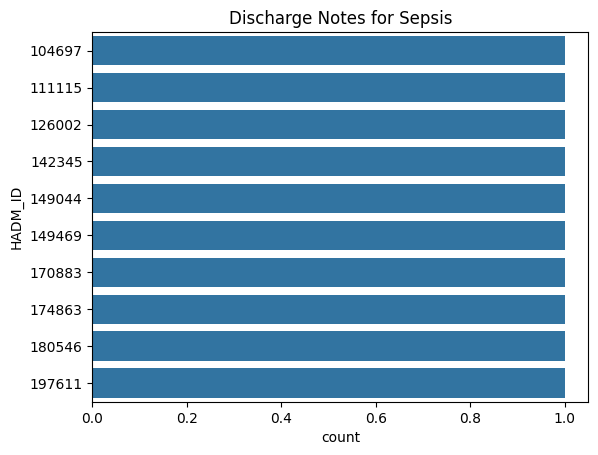

In [ ]:
# Visualizing Discharge Notes for Sepsis
sns.countplot(y=sepsis_summary["HADM_ID"])
plt.title("Discharge Notes for Sepsis")
plt.show()



In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_craft_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_jnlpba_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 36.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.2/989.2 kB 22.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached thinc-8.0.17-cp311-cp311-linux_x86_64.whl
  Using cached blis-0.7.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.4 kB)
  Using cached wasabi-0.10.1-py3-none-any.whl.metadata (28 kB)
  Using cached pathy-0.11.0-py3-none-any.whl.metadata (16 kB)
  Using cached smart_open-6.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached pydantic-1.8.2-py3-none-any.whl.metadata (103 kB)
  Using cached pathlib_abc-0.1.1-py3-none-any.whl.metadata (18 kB)
Using cached blis-0.7.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.2 MB)
Using cached pathy-0.11.0-py3-none-any.whl (47 kB)
Using cached pathlib_abc-0.1.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 MB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_ner_craft_md: filename=en_ner_craft_md-0.4.0-py3-none-any.whl size=125689493 sha256=5d3e50782e75de235dfb20c87b5b2dc0bdc1ce1c4a2de84db7f0b41e5700b72b
  Stored in directory: /root/.cache/pip/wheels/11/4b/84/a1274d01edd39e50470dc87d46bf56740f8cea26e5b8be6719
Successfully built en_ner_craft_md
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 MB 40.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_ner_jnlpba_md: filename=en_ner_jnlpba_md-0.4.0-py3-none-any.whl size=125691816 sha256=a030a380ce4f55ec568a98b335407390dc056c13c49726f6074a7daa902c9430
  Stored in directory: /root/.cache/pip/wheels/44/03/d8/86f184d322c8c76da57e277736b1d2ad5350247507bc6c38ea
Successfully built en_ner_jnlpba_md
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 MB 37.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... do

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
# Load NLP Models
nlp_spacy = spacy.load("en_core_web_sm")
nlp_scispacy = spacy.load("en_core_sci_md")

# Entity Extraction
def extract_entities(text, model):
    doc = model(text)
    return [(ent.text, ent.label_) for ent in doc.ents]



  Using cached spacy-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached thinc-8.3.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached blis-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
Using cached spacy-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.6 MB)
Using cached thinc-8.3.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.9 MB)
Using cached blis-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uninstalled blis-0.7.11
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.17
    Uninstalling thinc-8.0.17:
      Successfully uninstalled thinc-8.0.17
  Attempting uninstall: spacy
    Found existing installation: spacy 3.0.9
    Uninstalling spacy-3.0.9:
      Su

NameError: name 'spacy' is not defined

In [ ]:
sepsis_summary["spacy_entities"] = sepsis_summary["TEXT"].apply(lambda x: extract_entities(x, nlp_spacy))
sepsis_summary["scispacy_entities"] = sepsis_summary["TEXT"].apply(lambda x: extract_entities(x, nlp_scispacy))

# Display entity extraction results to console
print("\nNamed Entity Extraction Sample (SpaCy):")
print(sepsis_summary[["SUBJECT_ID", "HADM_ID", "spacy_entities"]].head())

print("\nNamed Entity Extraction Sample (SciSpacy):")
print(sepsis_summary[["SUBJECT_ID", "HADM_ID", "scispacy_entities"]].head())
# Word2Vec for Sepsis
sentences = [note.split() for note in sepsis_summary["TEXT"].dropna()]
word2vec_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)
word_vectors = word2vec_model.wv



NameError: name 'sepsis_summary' is not defined

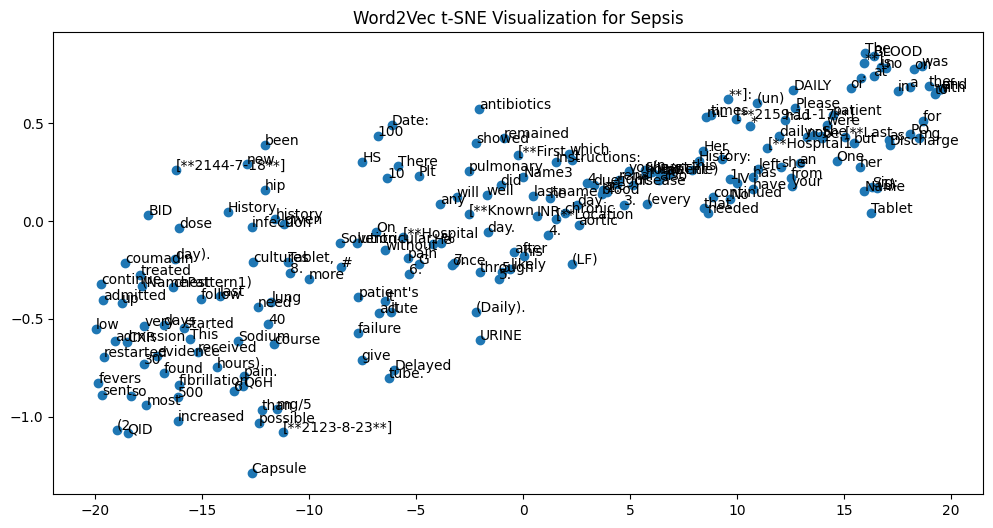

In [ ]:
# t-SNE Visualization for Word2Vec
def tsne_plot(model, title):
    words = list(model.index_to_key)[:200]
    X = model[words]
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(12, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, xy=(X_tsne[i, 0], X_tsne[i, 1]))
    plt.title(title)
    plt.show()

tsne_plot(word_vectors, "Word2Vec t-SNE Visualization for Sepsis")



In [ ]:
# ClinicalBERT Embeddings
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
sepsis_summary["bert_embeddings"] = sepsis_summary["TEXT"].apply(get_bert_embeddings)

# Save Processed Data
sepsis_summary.to_csv("processed_sepsis_summary.csv", index=False)
print("NLP processing complete. Data merged and saved.")


NLP processing complete. Data merged and saved.
